# Sugestie
* ip embedding
* target encoding
* bucketing
* hash semantyczny
* isolation forest / SVM
* pca



# Przygotowanie danych

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sympy import Integer
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import hashlib
from sklearn.metrics import confusion_matrix

## Import danych

In [7]:
# url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/reduced_dataset_sdn.csv'
url = 'https://raw.githubusercontent.com/wiktorDeka/WykrywanieAnomalii/main/dataset_sdn.csv'
s = requests.get(url).content

counters = pd.read_csv(io.StringIO(s.decode('utf-8')))
counters.dt = pd.to_datetime(counters.dt, unit='s')
counters.set_index('dt', inplace=True)

counters

,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
dt,,,,,,,,,,,,,,,,,,,,,
1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,...,0,0,ICMP,1,15209,12720,1,1.0,2.0,0
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,79,7742,81,842000000,8.184200e+10,5,10,...,0,0,ICMP,3,15099,14693,1,1.0,2.0,0
1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,31,3038,31,805000000,3.180500e+10,5,10,...,1,0,ICMP,2,3409,3731,0,0.0,0.0,0


## Przygotowanie danych – brakujące dane

Usunięcie całych obserwacji w których występuje brak danych. Często metodę określa się z angielskiego jako complete-case analysis (CCA), czyli analizie poddajemy tylko te obserwacje dla których mamy pełne dane dla wszystkich zmiennych. W naszym przypadku z uwagi na relatywnie niską liczebność, postanowiliśmy braki pominąć.

In [8]:
counters.dropna(inplace=True)
counters.isnull().sum()


switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

## Przygotowanie danych - kodowanie zmiennych kategorialnych

Dla przypomnienia zmienna kategorialna to taka, która pozwala na przeprowadzenie klasyfikacji serii danych za pomocą wartości związanych z określoną jakością czy kategorią. Zmienna kategorialna pozwala sklasyfikować, pogrupować w oparciu o informację jakościową, czyli najczęściej w danych spotkamy zmienną kategorialną z elementami stanowiącymi łańcuch tekstowy. W naszym przypadku będziemy zaliczać do zmiennych kategorialnych : data/czas danych wpisów, nazwa protokołu jaki został uzyty, destination i source adresy.

Na podstawie róznych benchamrków, mozemy się skupić na tych 4 enkoderach.

"We observed that four encoders: One-Hot, Binary (‘Bin’ on the plot), Sum, and Weight of Evidence are consistently among the best performing. For logistic regression, the difference of these four from the rest is statistically significant."


## Przygotowanie danych - duration

Łączymy duration_sec i duration_nsec, aby otrzymać pełny czas trwania - duration.


In [9]:
# Create the new 'duration' column

if 'dur' in counters and 'dur_nsec' in counters:
  counters['duration'] = counters['dur'] + counters['dur_nsec'] / 1e9

  # Drop the 'duration_sec' and 'duration_nsec' columns
  counters = counters.drop(['dur', 'dur_nsec'], axis=1)

counters[['duration']].sample(n=10)

,duration
dt,
1970-01-01 06:53:00,343.187
1970-01-01 06:54:00,453.242
1970-01-01 06:50:41,266.279
1970-01-01 00:55:09,156.423
1970-01-01 03:07:25,70.781
1970-01-01 03:12:55,250.568
1970-01-01 06:54:00,403.214
1970-01-01 03:59:35,61.262
1970-01-01 01:09:47,181.149


## Normalizacja

Normalizacja to proces przekształcania danych wejściowych w taki sposób, aby poprawić wydajność modelu uczącego się. Głównym celem normalizacji jest doprowadzenie danych do jednolitej skali lub rozkładu, co może ułatwić uczenie modelu poprzez zmniejszenie wpływu różnic w zakresach lub jednostkach między różnymi cechami danych.

Istnieje kilka popularnych metod normalizacji danych, takich jak:

Normalizacja min-max: Skaluje wartości cech do zakresu między 0 a 1, wykorzystując minimum i maksimum wartości danej cechy.
Z-score normalization (StandardScaler): Przekształca wartości cech tak, aby miały średnią równą zero i odchylenie standardowe równe jeden.
Normalizacja jednostkowa: Polega na dzieleniu każdej wartości cechy przez normę wektora cechy, co prowadzi do przeskalowania cech do jednostkowego wektora o długości 1.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'counters' is your DataFrame
# columns_to_normalize = ['pktcount', 'bytecount', 'tx_bytes', 'rx_bytes']
columns_to_normalize = ['pktcount', 'bytecount', 'tot_dur', 'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'duration']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
counters[columns_to_normalize] = scaler.fit_transform(counters[columns_to_normalize])
counters

,switch,src,dst,pktcount,bytecount,tot_dur,flows,packetins,pktperflow,byteperflow,...,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,duration
dt,,,,,,,,,,,,,,,,,,,,,
1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,0.174242,0.328245,0.053723,0.066667,0.076883,0.962331,0.996744,...,0.0,UDP,3,1.133295e-01,3.090061e-06,0.000000,0.00000,0.000000,0,0.053531
1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,0.486123,0.915781,0.149468,0.000000,0.076883,0.962304,0.996717,...,0.0,UDP,4,1.035450e-06,2.689292e-06,0.000000,0.00000,0.000000,0,0.149210
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,1,9.984414e-07,3.896647e-07,0.000000,0.00000,0.000000,0,0.106695
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,2,9.141880e-07,6.420382e-07,0.000000,0.00000,0.000000,0,0.106695
1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,0.347427,0.654498,0.106915,0.066667,0.076883,0.962324,0.996737,...,0.0,UDP,3,6.976491e-07,2.835669e-06,0.000000,0.00000,0.000000,0,0.106695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,0.043533,0.200000,0.000238,0.872365,0.907365,...,0.0,ICMP,1,9.985988e-06,1.197664e-05,0.000049,0.00006,0.000097,0,0.043499
1970-01-01 01:27:42,3,10.0.0.5,10.0.0.7,0.000304,0.000053,0.043533,0.200000,0.000238,0.872365,0.907365,...,0.0,ICMP,3,9.899373e-06,1.396837e-05,0.000049,0.00006,0.000097,0,0.043499
1970-01-01 01:27:42,3,10.0.0.11,10.0.0.5,0.000119,0.000021,0.016918,0.200000,0.000238,0.872371,0.907365,...,0.0,ICMP,2,6.944994e-07,2.902295e-06,0.000000,0.00000,0.000000,0,0.016904


## Target encoding


In [11]:
from sklearn import preprocessing

encoder = preprocessing.TargetEncoder()
src_encoded = encoder.fit_transform(counters[['src']], counters['label'])
counters['src'] = src_encoded
dst_encoded = encoder.fit_transform(counters[['dst']], counters['label'])
counters['dst'] = dst_encoded

counters[['src', 'dst']].sample(n=10)

,src,dst
dt,,
1970-01-01 00:44:28,0.733444,0.451795
1970-01-01 03:07:25,0.230252,0.419781
1970-01-01 00:54:39,0.197479,0.371442
1970-01-01 06:56:30,0.192711,0.419781
1970-01-01 01:50:42,0.182664,0.239855
1970-01-01 02:43:36,0.693715,0.431229
1970-01-01 06:47:11,0.287380,0.530252
1970-01-01 01:24:47,0.212080,0.197176
1970-01-01 09:06:33,0.425844,0.487719


## Label encoding

Z uwagi na małą pulę adresów src, dst zdecydowaliśmy się na użycie prostego label encoding

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
src_enc = le.fit_transform(counters['src'])
dst_enc = le.fit_transform(counters['dst'])
counters['src'], counters['dst'] = src_enc, dst_enc

counters[['src', 'dst']].sample(n=10)

,src,dst
dt,,
1970-01-01 08:22:42,39,6
1970-01-01 02:44:36,71,51
1970-01-01 07:31:47,8,55
1970-01-01 07:24:17,35,22
1970-01-01 01:10:47,60,2
1970-01-01 07:32:17,5,51
1970-01-01 08:23:12,32,52
1970-01-01 03:09:25,88,50
1970-01-01 02:12:07,57,60


## Kodowanie One-Hot Encoding/DummyVariable Encoding

Dla zmiennych kategorialnych bez uporządkowania kodowanie numeryczne, a więc określające relację między kategoriami może prowadzić do niewłaściwego działania uczonego modelu. Wymuszenie uporządkowania, tak jak zrobiliśmy to poprzednio też nie jest dobrym rozwiązaniem. Dla takich przypadków stosuje się kodowanie One-Hot Encoding, które w języku polskim określa się jako kodowanie „1 z n”. Poniewaz dane wypisane powyzej mają mieć tylko postać rozróznienia kategorii / grup osoób, skorzystamy z tego kodowanie. W naszym wypadku występuje jednak problem ilości róznych kategorii w odniesieniu do adresów IP

In [13]:
if 'Protocol' in counters:
  usecols = ['Protocol']
  df = counters[usecols]
  # df = df.fillna(value='missing')
  encoded_columns = pd.get_dummies(df, drop_first=False, dtype=int)
  counters = pd.concat([counters, encoded_columns], axis=1)
  counters.drop(columns=usecols, inplace=True)

counters[['Protocol_UDP', 'Protocol_TCP', 'Protocol_ICMP']].sample(n=10)


,Protocol_UDP,Protocol_TCP,Protocol_ICMP
dt,,,
1970-01-01 03:16:55,1,0,0
1970-01-01 01:55:12,0,0,1
1970-01-01 04:03:35,0,1,0
1970-01-01 02:49:36,1,0,0
1970-01-01 08:34:12,0,0,1
1970-01-01 07:41:48,0,0,1
1970-01-01 01:11:17,0,1,0
1970-01-01 08:37:51,0,0,1
1970-01-01 01:56:42,0,0,1


# Wizualizacja

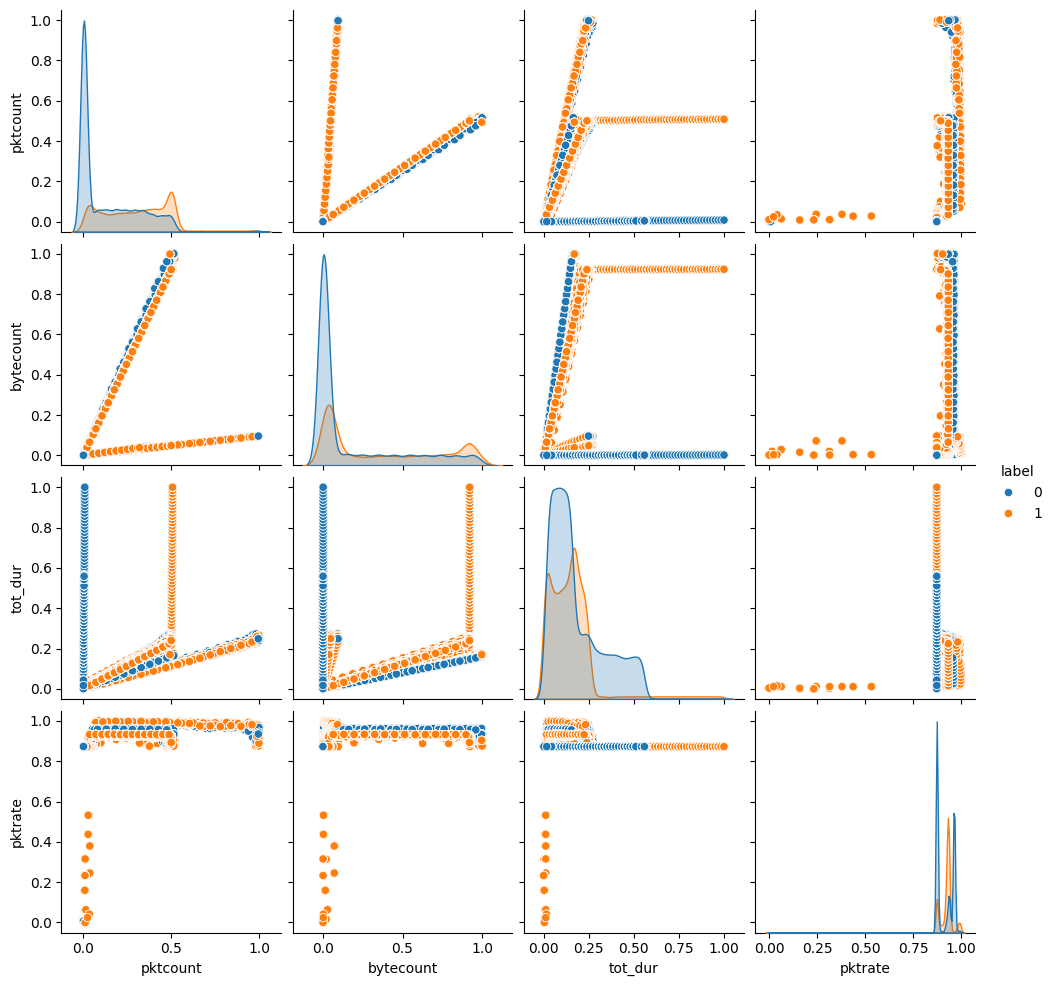

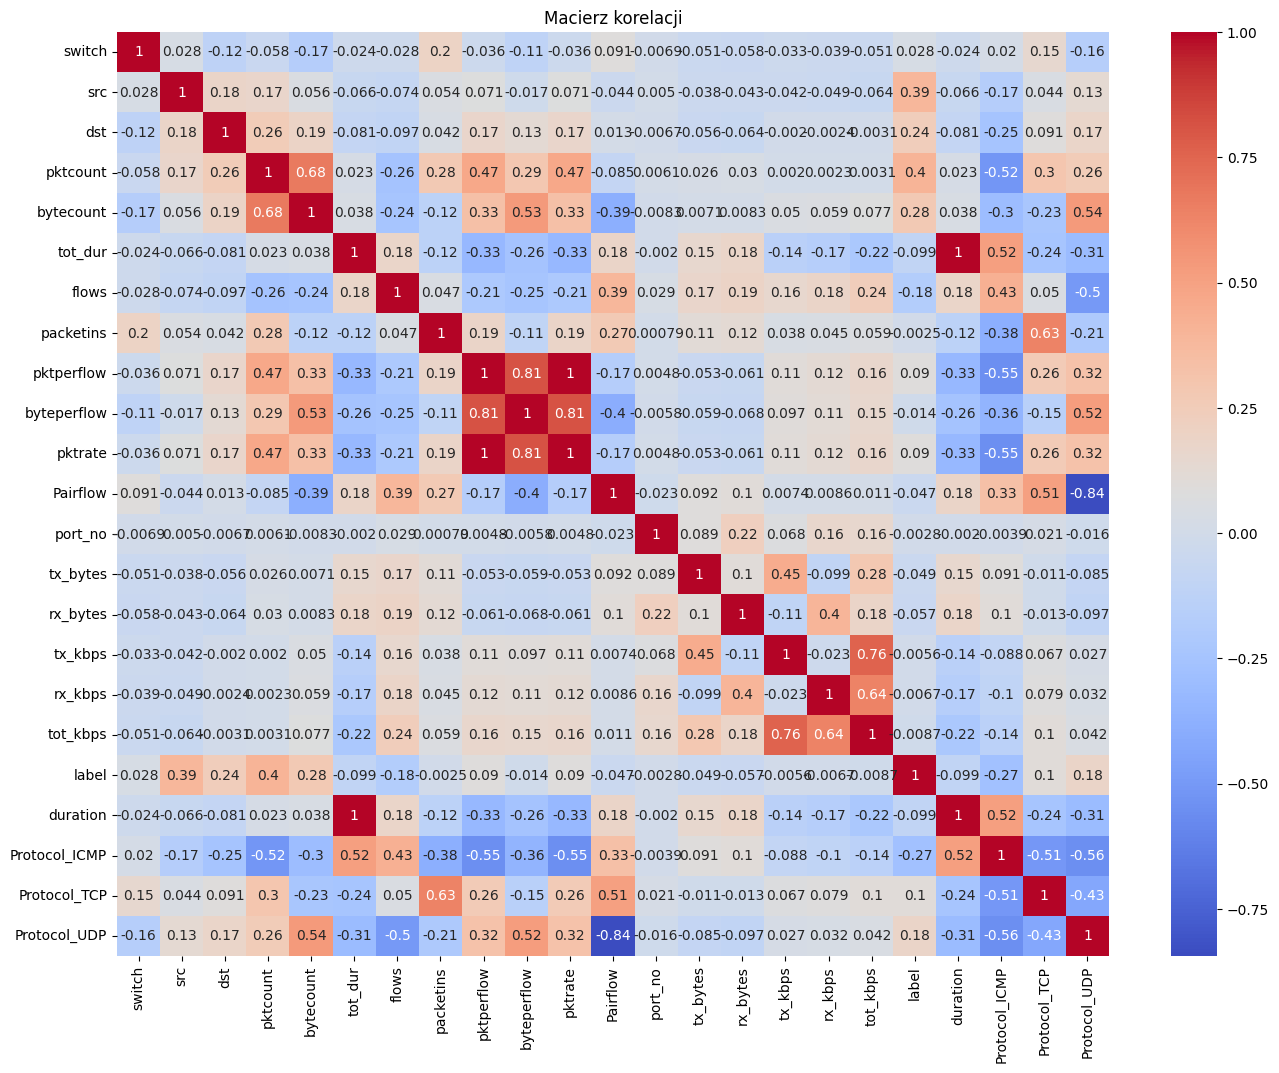

In [14]:
sns.pairplot(counters, hue='label', vars=['pktcount', 'bytecount', 'tot_dur', 'pktrate'])
plt.show()

plt.figure(figsize=(16, 12))
correlation_matrix = counters.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

# Uczenie maszynowe


label
0    63335
1    40504
Name: count, dtype: int64


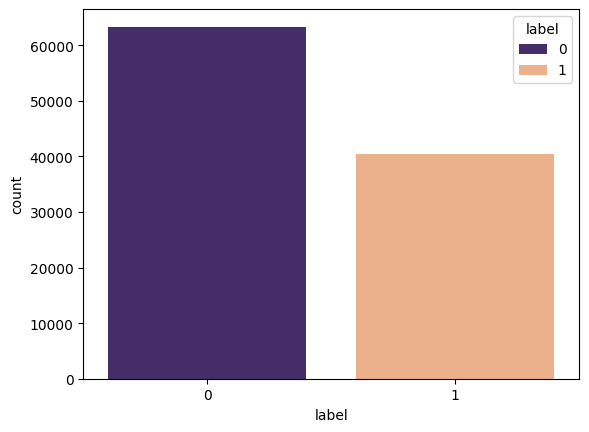

In [15]:
sns.countplot(x=counters['label'], palette=['#432371',"#FAAE7B"], hue=counters['label'])
print(counters['label'].value_counts())

## Podział danych na testowe i treningowe

Splitujemy dane w proporcji 70/30 (uczenie/test)

In [16]:
from sklearn.model_selection import train_test_split

y = counters['label']
X = counters.drop('label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

KNN opiera się na założeniu, że podobne dane znajdują się blisko siebie w przestrzeni cech. Podczas klasyfikacji nowego punktu danych, algorytm identyfikuje kk najbliższych sąsiadów (punktów z zestawu treningowego) i przydziela klasę, która jest najczęściej reprezentowana wśród tych sąsiadów.

### Optymalizacja

In [17]:
from sklearn import neighbors

K = []
training = []
test = []
scores = {}
best = 0

for k in range(2, 21):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    if best < test_score:
        best = test_score
        best_k = k

    print(k, '', test_score)

print(f"Najlepszy hiperparametr k = {best_k}")

2  0.9075821777092964
3  0.9155752439650745
4  0.9153826399589111
5  0.919138418079096
6  0.9164740626605034
7  0.9181753980482794
8  0.9162493579866461
9  0.9170197740112994
10  0.9147085259373395
11  0.9157678479712378
12  0.9130392912172574
13  0.9138097072419107
14  0.9120120698510529
15  0.913135593220339
16  0.9113058551617874
17  0.912557781201849
18  0.9113700564971752
19  0.9120762711864406
20  0.9102786337955829
Najlepszy hiperparametr k = 5


### Wdrożenie

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     18986
           1       0.93      0.86      0.89     12166

    accuracy                           0.92     31152
   macro avg       0.92      0.91      0.91     31152
weighted avg       0.92      0.92      0.92     31152



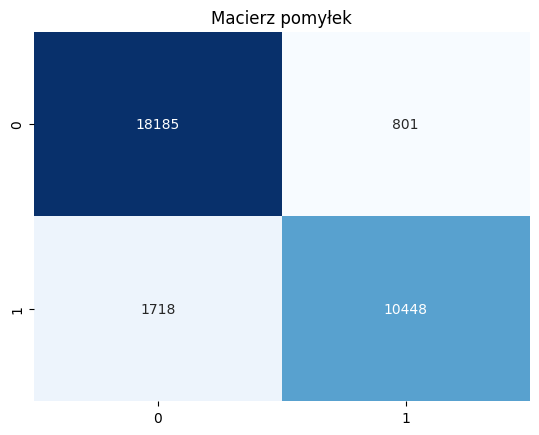

In [18]:

clf = neighbors.KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()


## SVM

Support Vector Machine (SVM) to potężny algorytm uczenia maszynowego używany zarówno do klasyfikacji, jak i regresji. Głównym celem SVM jest znalezienie optymalnej hiperpłaszczyzny, która maksymalnie oddziela klasy w przestrzeni cech. SVM działa dobrze na danych o wysokiej wymiarowości i jest skuteczny w przypadku problemów liniowo separowalnych, a także nieliniowych dzięki zastosowaniu tzw. funkcji jądrowych (kernel functions). W przypadku klasyfikacji, SVM dąży do maksymalizacji marginesu, czyli odległości między najbliższymi punktami danych (wektorami nośnymi) a hiperpłaszczyzną separującą.

### Optymalizacja

In [19]:
from sklearn import svm

_ = 0

if _ == 1:
    for i in range(1, 20, 1):
        actual_gamma = i / 100
        ksvm = svm.SVC(kernel='rbf', gamma=actual_gamma)
        # Train the model on the training data
        ksvm.fit(X_train, y_train)
        # Evaluate the model on the test data
        accuracy = ksvm.score(X_test, y_test)
        print(f'Accuracy with gamma {actual_gamma} :', accuracy)
    for j in range(1, 20, 1):
        for i in range(1, 20, 1):
            actual_gamma = i / 100
            actual_nu = j / 100
            clf = svm.OneClassSVM(kernel='rbf', gamma=actual_gamma, nu=actual_nu)
            clf.fit(X_train)

            y_pred_test = clf.predict(X_test)
            y_pred_test = [0 if y == 1 else 1 for y in y_pred_test]
            n_error_test = (y_pred_test != y_test).sum()
            test_accuracy = (len(y_test) - n_error_test) / len(y_test)
            print(f'One-Class SVM accuracy with gamma {actual_gamma} and nu {actual_nu}:', test_accuracy)

### Wdrożenie

#### SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     18986
           1       0.95      0.87      0.91     12166

    accuracy                           0.93     31152
   macro avg       0.94      0.92      0.93     31152
weighted avg       0.93      0.93      0.93     31152




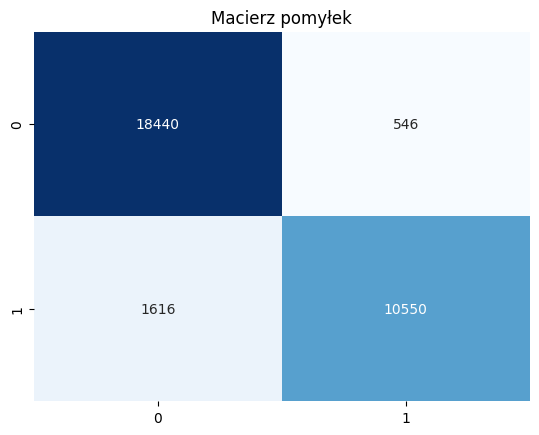

In [20]:
ksvm = svm.SVC(kernel='rbf', gamma=0.13)
ksvm.fit(X_train, y_train)
y_pred = ksvm.predict(X_test)
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}\n')

sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

#### OneClassSVM

              precision    recall  f1-score   support

           0       0.61      0.96      0.75     18986
           1       0.45      0.05      0.08     12166

    accuracy                           0.61     31152
   macro avg       0.53      0.50      0.42     31152
weighted avg       0.55      0.61      0.49     31152



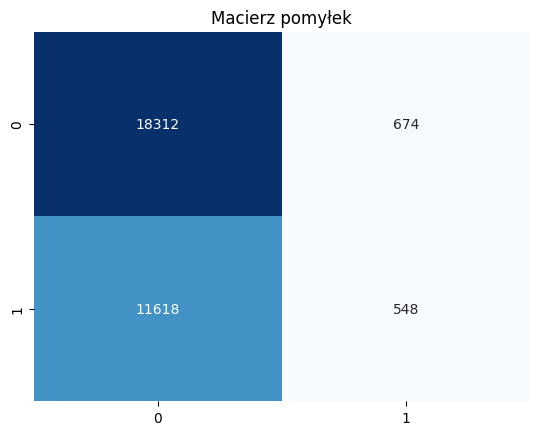

In [21]:
clf = svm.OneClassSVM(kernel='rbf', gamma=0.04, nu=0.03)
clf.fit(X_train)

y_pred_test = clf.predict(X_test)
y_pred_test = [0 if y == 1 else 1 for y in y_pred_test]
report = classification_report(y_test, y_pred_test)
print(report)

sns.heatmap(confusion_matrix(y_test, y_pred_test), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

## Sieci neuronowe - prosty perceptron

Jest to prosty model neuronowy, który naśladuje działanie biologicznych neuronów. Perceptron przyjmuje wiele wejść, przetwarza je za pomocą wag, a następnie stosuje funkcję aktywacji (najczęściej funkcję skoku jednostkowego), aby wygenerować wyjście. Działa jako liniowy klasyfikator, który potrafi rozdzielać dane liniowo separowalne, ucząc się poprzez modyfikację wag w odpowiedzi na błędy przewidywań w procesie treningowym. 

### Optymalizacja

In [22]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

max_iter_range = range(500, 2000, 100)
tol_values = [5e-4, 1e-3, 2e-3, 4e-3]
results = []

for max_iter in max_iter_range:
    for tol in tol_values:
        perceptron = Perceptron(max_iter=max_iter, tol=tol)
        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append((max_iter, tol, accuracy))

sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

for max_iter, tol, accuracy in sorted_results:
    print(f"max_iter: {max_iter}, tol: {tol}, Accuracy: {accuracy:.4f}")

max_iter: 500, tol: 0.0005, Accuracy: 0.5731
max_iter: 500, tol: 0.001, Accuracy: 0.5731
max_iter: 500, tol: 0.002, Accuracy: 0.5731
max_iter: 500, tol: 0.004, Accuracy: 0.5731
max_iter: 600, tol: 0.0005, Accuracy: 0.5731
max_iter: 600, tol: 0.001, Accuracy: 0.5731
max_iter: 600, tol: 0.002, Accuracy: 0.5731
max_iter: 600, tol: 0.004, Accuracy: 0.5731
max_iter: 700, tol: 0.0005, Accuracy: 0.5731
max_iter: 700, tol: 0.001, Accuracy: 0.5731
max_iter: 700, tol: 0.002, Accuracy: 0.5731
max_iter: 700, tol: 0.004, Accuracy: 0.5731
max_iter: 800, tol: 0.0005, Accuracy: 0.5731
max_iter: 800, tol: 0.001, Accuracy: 0.5731
max_iter: 800, tol: 0.002, Accuracy: 0.5731
max_iter: 800, tol: 0.004, Accuracy: 0.5731
max_iter: 900, tol: 0.0005, Accuracy: 0.5731
max_iter: 900, tol: 0.001, Accuracy: 0.5731
max_iter: 900, tol: 0.002, Accuracy: 0.5731
max_iter: 900, tol: 0.004, Accuracy: 0.5731
max_iter: 1000, tol: 0.0005, Accuracy: 0.5731
max_iter: 1000, tol: 0.001, Accuracy: 0.5731
max_iter: 1000, tol: 0.0

### Wdrożenie

              precision    recall  f1-score   support

           0       0.92      0.33      0.48     18986
           1       0.48      0.95      0.64     12166

    accuracy                           0.57     31152
   macro avg       0.70      0.64      0.56     31152
weighted avg       0.75      0.57      0.54     31152



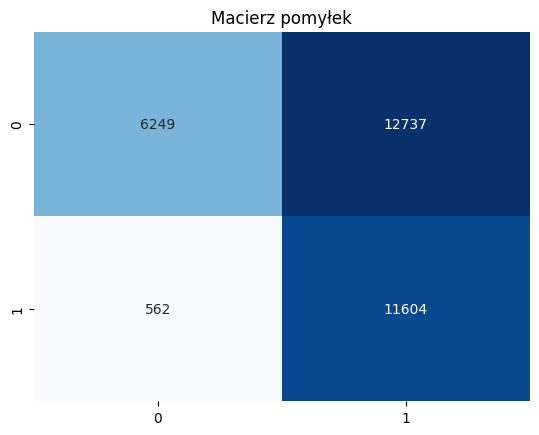

In [23]:
perceptron = Perceptron(max_iter=1200, tol=1e-3)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

## Drzewa decyzyjne

### Optymalizacja

In [24]:
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

criterion = 'entropy'
max_depth_values = range(1, 16)
min_samples_split_values = [2, 10, 20]
min_samples_leaf_values = [1, 5, 10]
max_features_values = [None, 'sqrt', 'log2']
max_leaf_nodes_values = [None, 10, 20]
min_impurity_decrease_values = [0.0, 0.01, 0.1]

results = []

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for min_samples_leaf in min_samples_leaf_values:
            for max_leaf_nodes in max_leaf_nodes_values:
                for min_impurity_decrease in min_impurity_decrease_values:
                    clf = tree.DecisionTreeClassifier(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    max_leaf_nodes=max_leaf_nodes,                    
                    min_impurity_decrease=min_impurity_decrease
                    )
                    clf.fit(X_train, y_train)
                        
                    # y_train_pred = clf.predict(X_train)
                    y_test_pred = clf.predict(X_test)
                        
                    # train_accuracy = accuracy_score(y_train, y_train_pred)
                    test_accuracy = accuracy_score(y_test, y_test_pred)
                    # train_precision = precision_score(y_train, y_train_pred, average='weighted')
                    test_precision = precision_score(y_test, y_test_pred, average='weighted')
                    # train_f1 = f1_score(y_train, y_train_pred, average='weighted')
                    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
                        
                    results.append({
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'max_leaf_nodes': max_leaf_nodes,
                        'min_impurity_decrease': min_impurity_decrease,
                        'test_accuracy': test_accuracy,
                        'test_precision': test_precision,
                        'test_f1': test_f1
                    })

results_df = pd.DataFrame(results)

print(results_df)

best_result = results_df.loc[results_df['test_accuracy'].idxmax()]
print("\nBest hyperparameters for test accuracy:")
print(best_result)

      max_depth  min_samples_split  min_samples_leaf  max_leaf_nodes  \
0             1                  2                 1             NaN   
1             1                  2                 1             NaN   
2             1                  2                 1             NaN   
3             1                  2                 1            10.0   
4             1                  2                 1            10.0   
...         ...                ...               ...             ...   
1210         15                 20                10            10.0   
1211         15                 20                10            10.0   
1212         15                 20                10            20.0   
1213         15                 20                10            20.0   
1214         15                 20                10            20.0   

      min_impurity_decrease  test_accuracy  test_precision   test_f1  
0                      0.00       0.690806        0.821867  0.68

Rysowanie drzewa decyzyjnego i wykres istotności poszczególnych cech dla modelu

                     switch  src  dst  pktcount  bytecount   tot_dur  \
dt                                                                     
1970-01-01 03:10:25       1   33   50  0.174242   0.328245  0.053723   
1970-01-01 03:13:25       1   33   46  0.486123   0.915781  0.149468   
1970-01-01 03:10:25       1    2   50  0.347427   0.654498  0.106915   
1970-01-01 03:10:25       1    1   46  0.347427   0.654498  0.106915   
1970-01-01 03:10:25       1    1   47  0.347427   0.654498  0.106915   
...                     ...  ...  ...       ...        ...       ...   
1970-01-01 01:27:42       3   24   54  0.000304   0.000053  0.043533   
1970-01-01 01:27:42       3   24   53  0.000304   0.000053  0.043533   
1970-01-01 01:27:42       3   15   35  0.000119   0.000021  0.016918   
1970-01-01 01:27:42       3   16   37  0.000119   0.000021  0.016918   
1970-01-01 01:27:42       3   19   37  0.000119   0.000021  0.016918   

                        flows  packetins  pktperflow  byteperfl

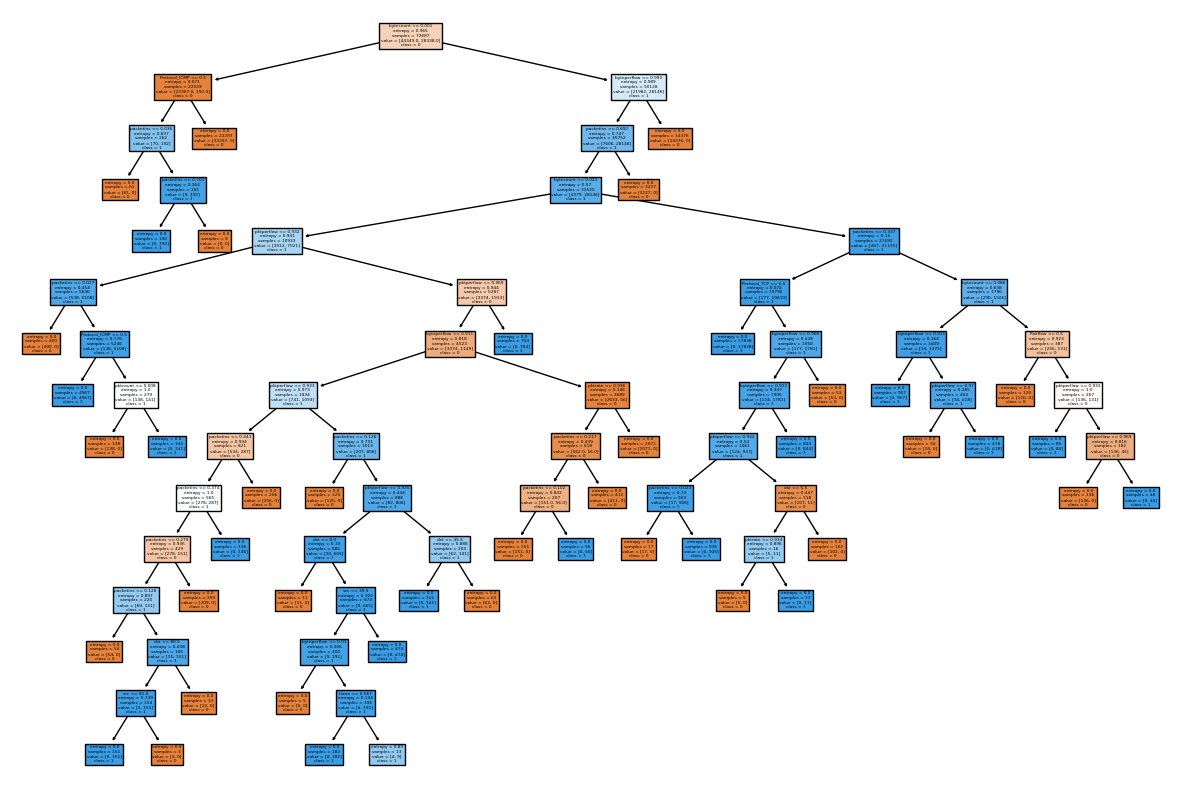

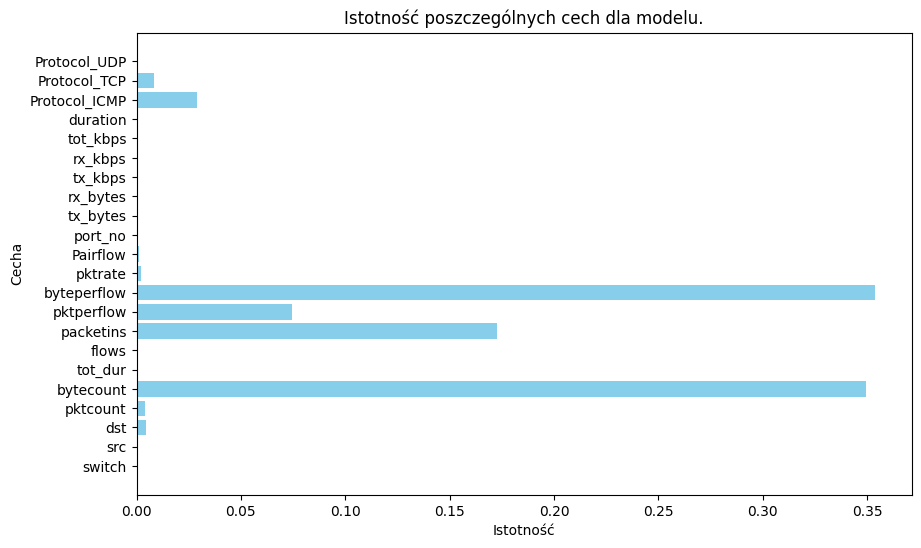

In [36]:
# y_train.drop(y_train.index[y_train.index == 'dt'], inplace=True)

print(counters)

max_depth = 14
min_samples_split = 2
min_samples_leaf = 1
drzewo = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
drzewo_data = drzewo.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
tree.plot_tree(
    drzewo_data,
    max_depth=15,
    class_names=['0', '1'],
    filled=True,
    feature_names=X_train.columns
)
plt.show()

feature_importances = drzewo.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances, color='skyblue')
plt.xlabel('Istotność')
plt.ylabel('Cecha')
plt.title('Istotność poszczególnych cech dla modelu.')
plt.show()

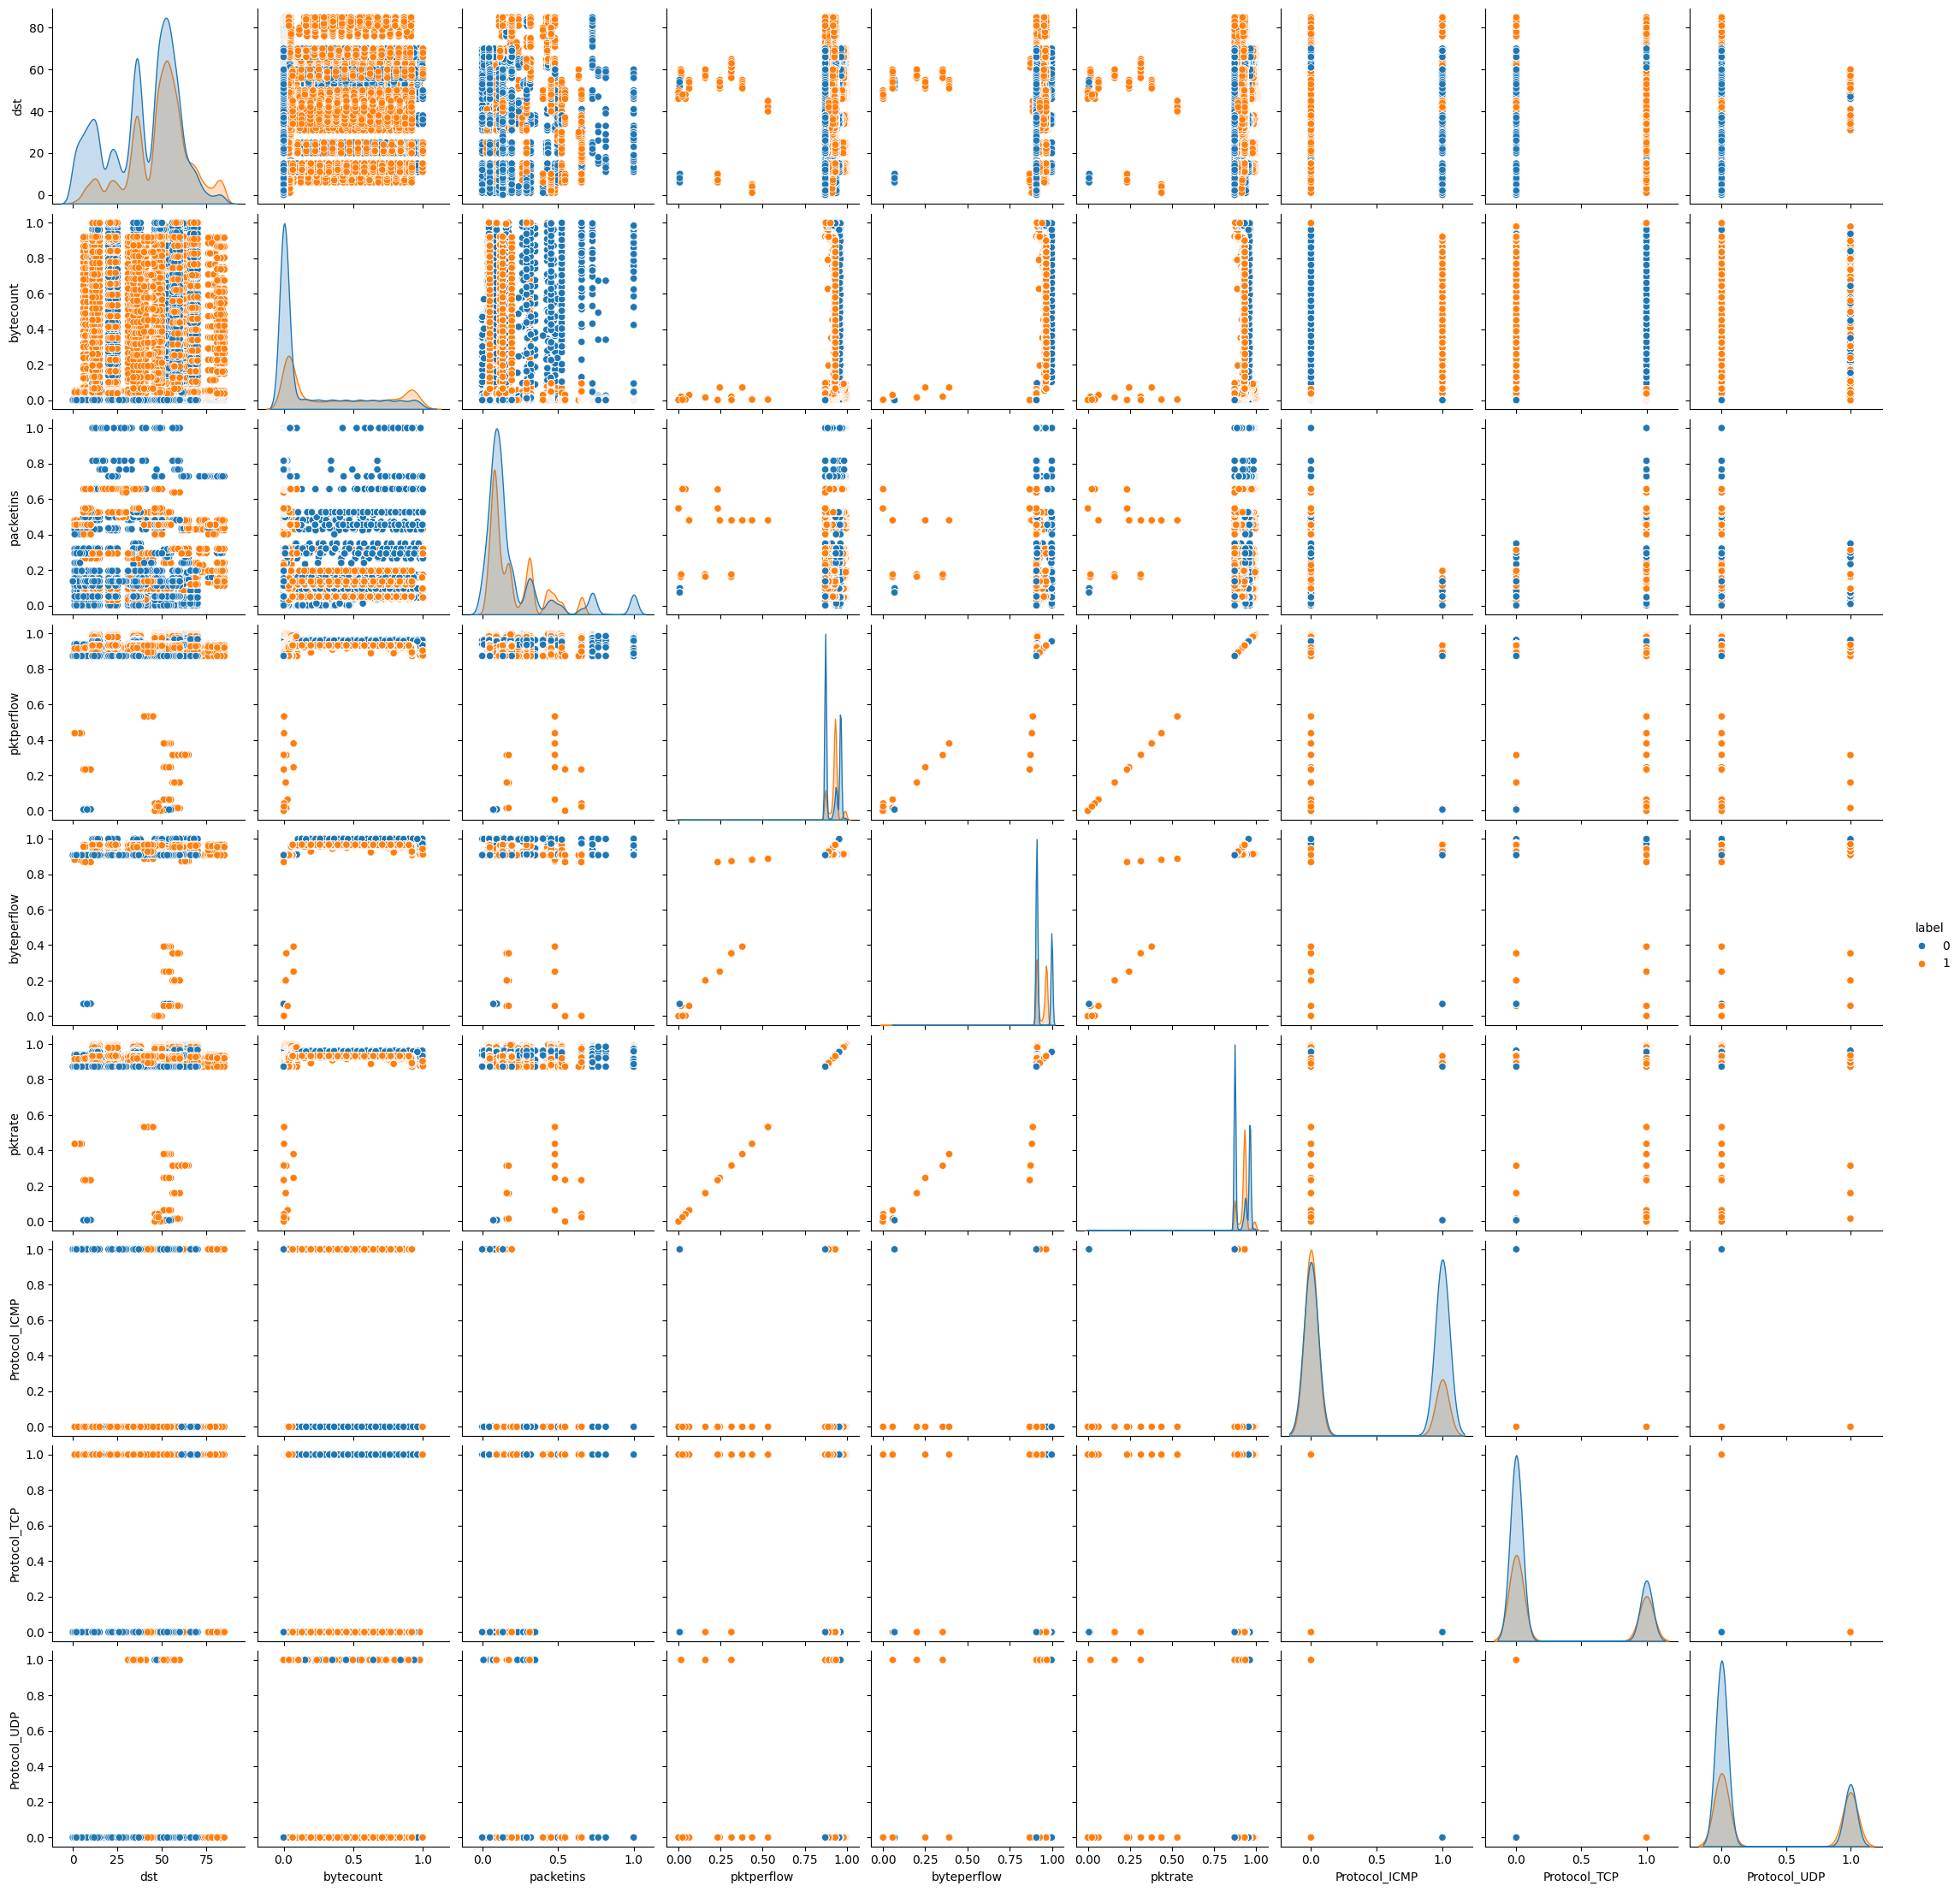

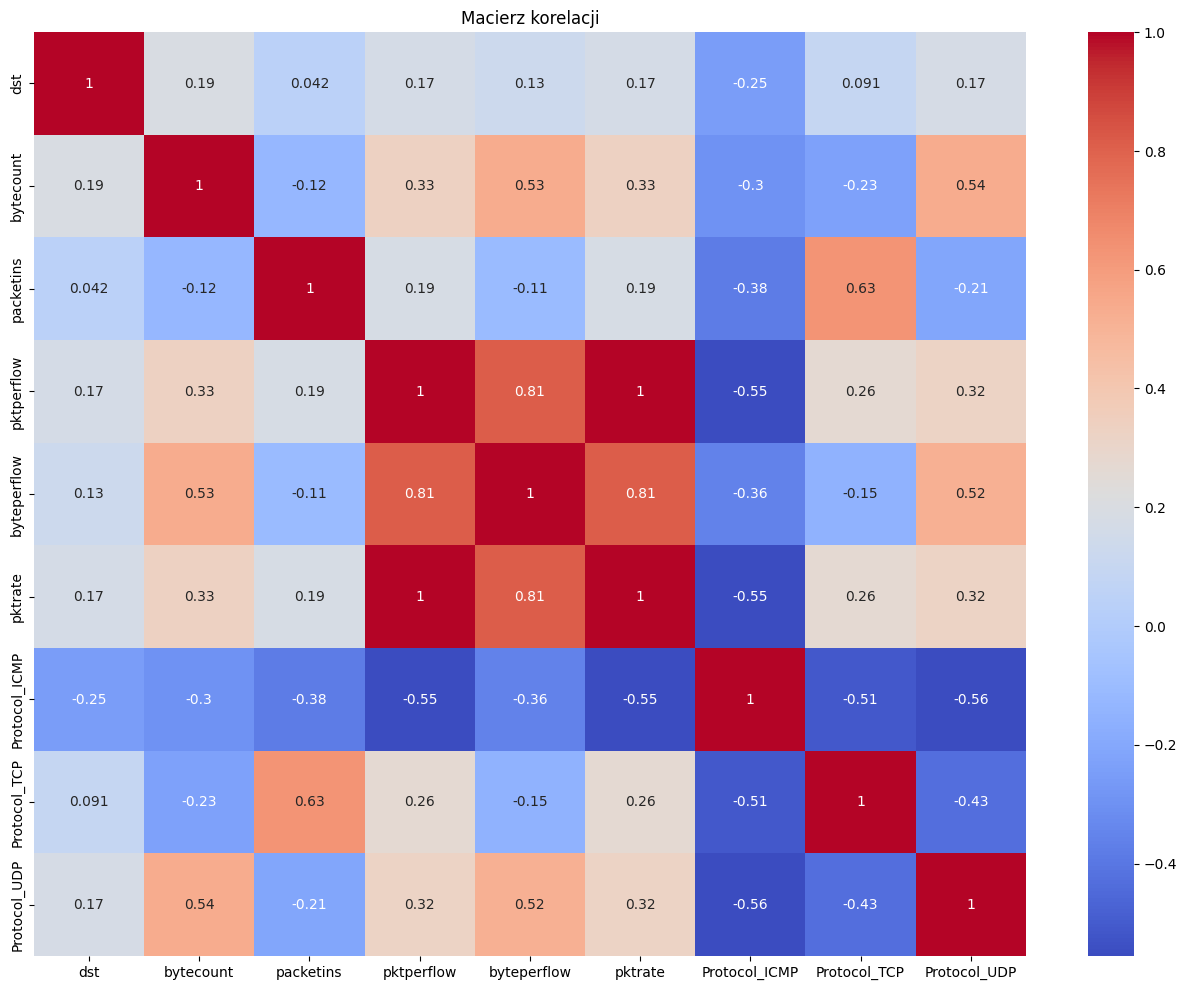

In [35]:
useful_features = X_train.columns[feature_importances > 0.001]

filtered_counters = counters[useful_features]

sns.pairplot(counters, hue='label', vars=useful_features)
plt.show()

plt.figure(figsize=(16, 12))
correlation_matrix = filtered_counters.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18986
           1       1.00      1.00      1.00     12166

    accuracy                           1.00     31152
   macro avg       1.00      1.00      1.00     31152
weighted avg       1.00      1.00      1.00     31152



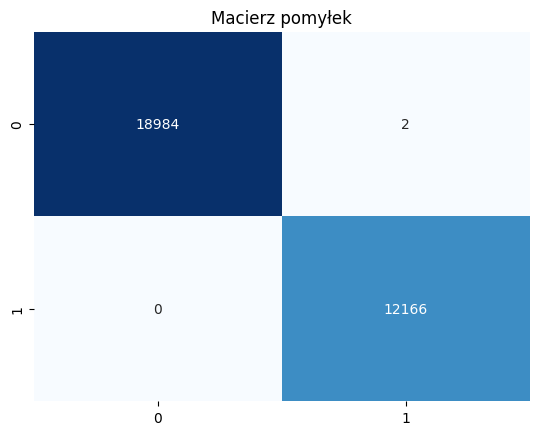

In [ ]:
clf = tree.DecisionTreeClassifier(
                    criterion='entropy',
                    max_depth=14,
                    min_samples_split=2,
                    min_samples_leaf=1,
                    max_leaf_nodes=None,                    
                    min_impurity_decrease=0
                    )

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()


## Isolation Forest

Dokładność:                precision    recall  f1-score   support

           0       0.64      0.76      0.69     18986
           1       0.47      0.34      0.39     12166

    accuracy                           0.59     31152
   macro avg       0.56      0.55      0.54     31152
weighted avg       0.57      0.59      0.58     31152



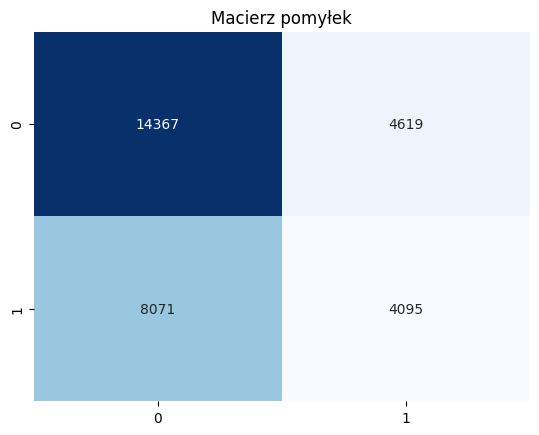

In [28]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest()
iso_forest.fit(X_train)

y_pred = iso_forest.predict(X_test)

y_pred_binary = np.where(y_pred == 1, 0, 1)

accuracy = classification_report(y_test, y_pred_binary)
print('Dokładność: ', accuracy)

sns.heatmap(confusion_matrix(y_test, y_pred_binary), fmt="d", annot=True, cmap='Blues', cbar=False)
plt.title('Macierz pomyłek')
plt.show()

In [29]:
n_estimators_values = [50, 100, 200]
max_samples_values = ['auto', 0.5, 0.75, 1.0]
contamination_values = [0.1, 0.2, 0.3]
max_features_values = [1.0, 0.5, 0.75]

# Store results in a list
results = []

# Iterate over different values of hyperparameters
for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:
        for contamination in contamination_values:
            for max_features in max_features_values:
                clf = IsolationForest(
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    contamination=contamination,
                    max_features=max_features,
                    random_state=42
                )
                clf.fit(X_train)
                
                # Predicting -1 for outliers and 1 for inliers
                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)
                
                # Convert predictions from -1 (outliers) and 1 (inliers) to binary classification
                y_train_pred = np.where(y_train_pred == 1, 0, 1)
                y_test_pred = np.where(y_test_pred == 1, 0, 1)
                
                train_accuracy = accuracy_score(y_train, y_train_pred)
                test_accuracy = accuracy_score(y_test, y_test_pred)
                train_precision = precision_score(y_train, y_train_pred, average='binary')
                test_precision = precision_score(y_test, y_test_pred, average='binary')
                train_f1 = f1_score(y_train, y_train_pred, average='binary')
                test_f1 = f1_score(y_test, y_test_pred, average='binary')
                
                results.append({
                    'n_estimators': n_estimators,
                    'max_samples': max_samples,
                    'contamination': contamination,
                    'max_features': max_features,
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    'train_precision': train_precision,
                    'test_precision': test_precision,
                    'train_f1': train_f1,
                    'test_f1': test_f1
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Find and print the best result for test accuracy
best_result = results_df.loc[results_df['test_accuracy'].idxmax()]
print("\nBest hyperparameters for test accuracy:")
print(best_result)

     n_estimators max_samples  contamination  max_features  train_accuracy  \
0              50        auto            0.1          1.00        0.604537   
1              50        auto            0.1          0.50        0.609077   
2              50        auto            0.1          0.75        0.608940   
3              50        auto            0.2          1.00        0.608018   
4              50        auto            0.2          0.50        0.623344   
..            ...         ...            ...           ...             ...   
103           200         1.0            0.2          0.50        0.634790   
104           200         1.0            0.2          0.75        0.625683   
105           200         1.0            0.3          1.00        0.623812   
106           200         1.0            0.3          0.50        0.640238   
107           200         1.0            0.3          0.75        0.627526   

     test_accuracy  train_precision  test_precision  train_f1  

# TODO:
* Feature importance
    - Random Forest
* Redukcja wymiarów
    - PCA [OK]*0.5
* Porównanie modeli
    - SVM etc... [OK]
    - accuracy, precision, F1-score [OK]
* Optymalizacja
    - tuning hiperparametrów [OK]
    - walidacja krzyżowa
* NN [OK]
